# Active Noise Cancellation - Simulation


### Introducción
introduccir del TP la explicación de ANC

### Objetivo y alcance
Para este proyecto vamos a realizar la simulación de un sistema de control de audio para llevar a cabo la cancelación activa de ruido. Para realizar este desarrollo vamos a implementar los conceptos estudiados en la materia de Teoría de control, dictada por la Universidad Tecnologica Nacional.
El objetivo principal va a ser lograr obtener las ondas senoidales de sonidos opuestas de distintos ruidos ambientes, estos sonidos ambientes los vamos a obtener de un dataset de acceso público.  
Al realizar este proyecto nos vamos a encontrar con ciertas limitantes que van a acotar el alcance del proyecto. A continuación se listan los puntos limitantes que dan lugar al alcance del trabajo:

### Implementación

Primero vamos a armar nuestro caso de prueba, donde vamos a generar un sonido en base a su onda senoidal, definiendo amplitud, frecuencia y fase.

In [6]:
#!pip install matplotlib
#!pip install numpy
!pip install scipy
!pip install sounddevice 

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [37]:
import time
import numpy as np
import pyaudio

p = pyaudio.PyAudio()

volume = 0.5  # rango [0.0, 1.0]
fs = 44100  # sampling rate, Hz, must be integer
duration = 10.0  # duracion del sonido
f = 440.0  # frecuencia senoidal - medida en Hz
ampl = 2

# generate samples, note conversion to float32 array
samples = (np.sin(ampl * np.pi * np.arange(fs * duration) * f / fs)).astype(np.float32)

# per @yahweh comment explicitly convert to bytes sequence
output_bytes = (volume * samples).tobytes()

# for paFloat32 sample values must be in range [-1.0, 1.0]
stream = p.open(format=pyaudio.paFloat32,
                channels=1,
                rate=fs,
                output=True)

# play. May repeat with different volume values (if done interactively)
start_time = time.time()
stream.write(output_bytes)
print("Played sound for {:.2f} seconds".format(time.time() - start_time))

stream.stop_stream()
stream.close()

p.terminate()

Played sound for 10.03 seconds


El sonido que se escucha al ejecutar el bloque anterior, va a ser nuestra simulación de ruido ambiente. Si bien este sonido está en condiciones ideales, nos va a servir a modo de ejemplo.  
A continuación se observa la onda senoidal que genera este sonido:

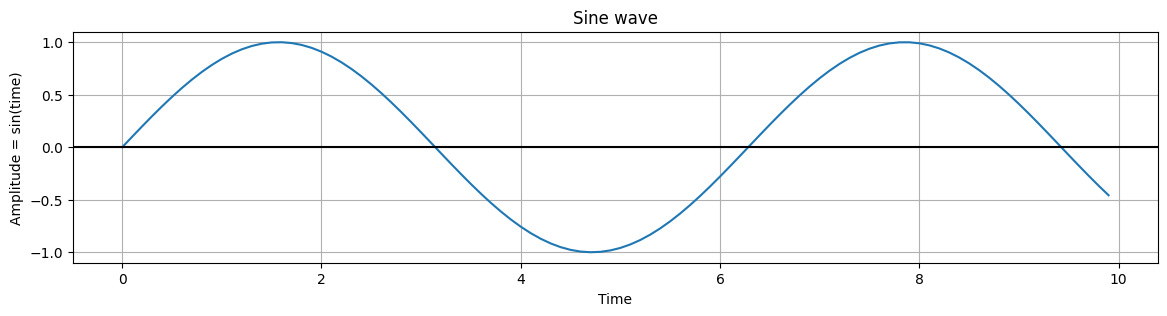

In [53]:
import numpy as np

import matplotlib.pyplot as plot

# Get x values of the sine wave
time = np.arange(0, 10, 0.1);

# Amplitude of the sine wave is sine of a variable like time
amplitude   = np.sin(time)

plot.figure(figsize=(14, 3))

# Plot a sine wave using time and amplitude obtained for the sine wave
plot.plot(time, amplitude)

# Give a title for the sine wave plot
plot.title('Sine wave')

# Give x axis label for the sine wave plot
plot.xlabel('Time')

# Give y axis label for the sine wave plot
plot.ylabel('Amplitude = sin(time)')

plot.grid(True, which='both')
plot.axhline(y=0, color='k')
plot.show()

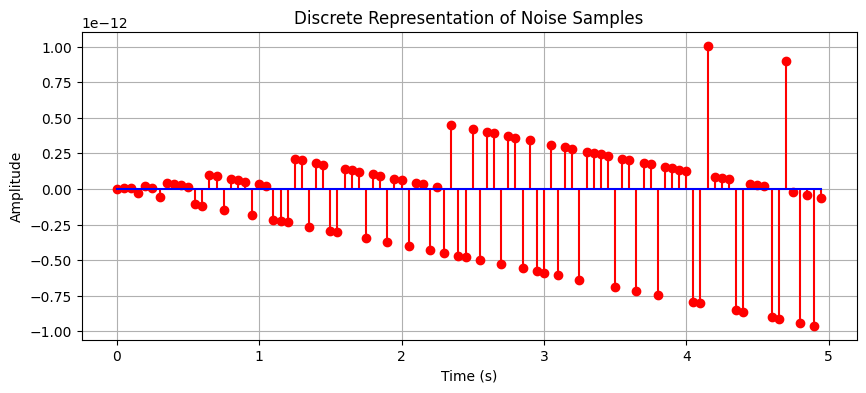

In [40]:
import time
import numpy as np
import pyaudio
import sounddevice as sd
import matplotlib.pyplot as plt
from scipy.signal import lfilter

# Configuración de PyAudio para generar la señal de ejemplo.
p = pyaudio.PyAudio()
volume = 0.5
fs = 10  # tasa de muestra --> Cantidad de muestras por segundo.
duration = 5.0
f = 440.0
ampl = 2

# Generamos muestras de ruido ambiente
noise_samples = (np.sin(ampl * np.pi * np.arange(fs * duration) * f / fs)).astype(np.float32)

# Crear un array de tiempo discreto para las muestras
time_discrete = np.arange(0, duration, 1/fs)

# Generar una señal senoidal continua
time_continuous = np.linspace(0, duration, num=64)  # Genera 1000 puntos en el dominio del tiempo
continuous_signal = ampl * np.sin(2 * np.pi * f * time_continuous)

# Graficar las muestras de forma discreta
plt.figure(figsize=(14, 4))
# plt.plot(time_continuous, continuous_signal, label='Continuous Signal')
plt.stem(time_discrete, noise_samples, basefmt="b-", linefmt="r-", markerfmt="ro")
plt.title('Discrete Representation of Noise Samples')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()



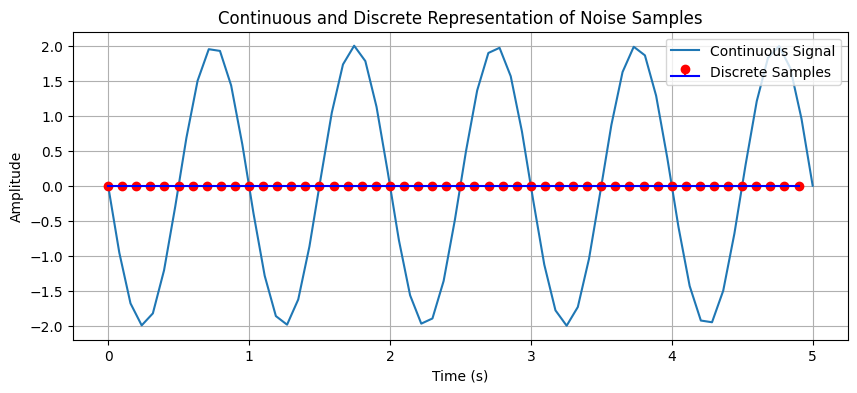

In [31]:
# Generar una señal senoidal continua
time_continuous = np.linspace(0, duration, num=64)  # Genera 1000 puntos en el dominio del tiempo
continuous_signal = ampl * np.sin(2 * np.pi * f * time_continuous)

# Generar muestras de ruido ambiente
noise_samples = (np.sin(ampl * np.pi * np.arange(fs * duration) * f / fs)).astype(np.float32)

# Crear un array de tiempo discreto para las muestras
time_discrete = np.arange(0, duration, 1/fs)

# Graficar la señal continua y las muestras discretas
plt.figure(figsize=(10, 4))
plt.plot(time_continuous, continuous_signal, label='Continuous Signal')
plt.stem(time_discrete, noise_samples, basefmt="b-", linefmt="r-", markerfmt="ro", label='Discrete Samples')
plt.title('Continuous and Discrete Representation of Noise Samples')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print("Seguimos con el proceso.")

# Convertir a bytes
noise_bytes = (volume * noise_samples).tobytes()

# Configuración de PyAudio para grabar
stream = p.open(format=pyaudio.paFloat32,
                channels=1,
                rate=fs,
                input=True)

print("Recording noise for {:.2f} seconds...".format(duration))
noise_input = stream.read(fs * int(duration))
print("Finished recording noise.")

stream.stop_stream()
stream.close()

# Almacenar el ruido para cancelación
noise_for_cancellation = np.frombuffer(noise_input, dtype=np.float32)

# Configuración de PyAudio para generar la señal de cancelación de ruido
samples = (np.sin(ampl * np.pi * np.arange(fs * duration) * f / fs)).astype(np.float32)

# Convertir a bytes
output_bytes = (volume * samples).tobytes()

# Configuración de PyAudio para reproducir la señal
stream = p.open(format=pyaudio.paFloat32,
                channels=1,
                rate=fs,
                output=True)

# Reproducir la señal original
print("Playing original sound...")
start_time = time.time()
stream.write(output_bytes)
print("Played sound for {:.2f} seconds".format(time.time() - start_time))

# Algoritmo de cancelación de ruido
mu = 0.01  # Ajusta este valor según sea necesario
clean_signal = samples - mu * lfilter(np.flip(noise_for_cancellation), 1, samples)

# Convertir la señal limpia a bytes
clean_bytes = (volume * clean_signal).tobytes()

# Reproducir la señal limpia
print("Playing cleaned sound...")
start_time = time.time()
stream.write(clean_bytes)
print("Played cleaned sound for {:.2f} seconds".format(time.time() - start_time))

# Visualizar la señal limpia
plt.figure(figsize=(10, 4))
plt.plot(np.arange(0, duration, 1/fs), clean_signal)
plt.title('Cleaned Waveform after Noise Cancellation')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

stream.stop_stream()
stream.close()
p.terminate()

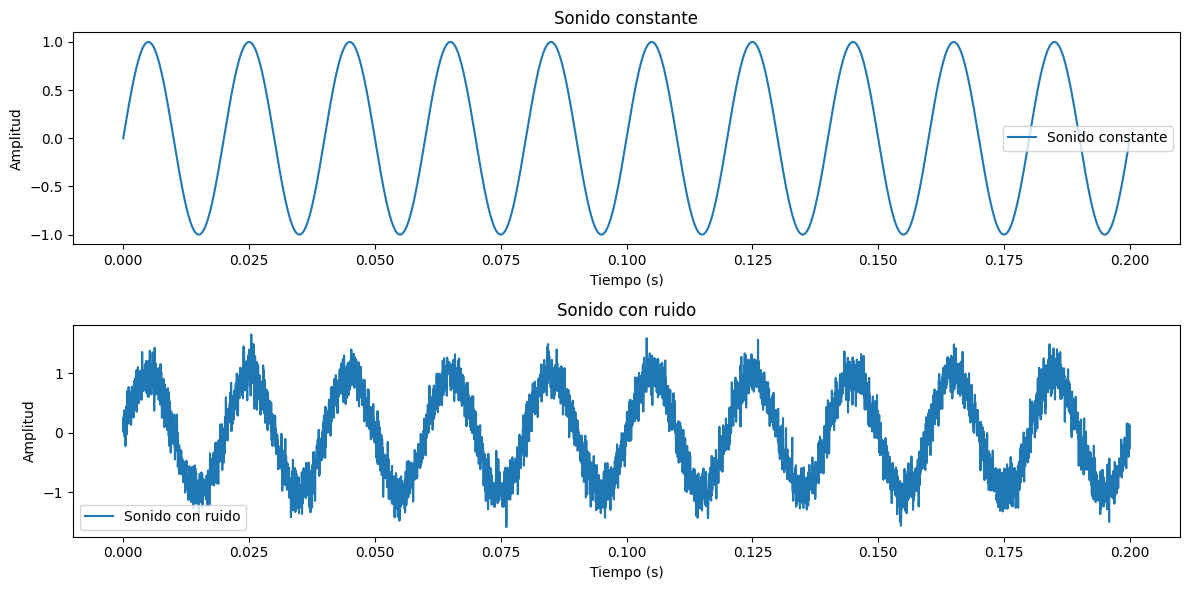

In [50]:
import numpy as np
import matplotlib.pyplot as plt

# Configuración de la simulación
fs = 1000  # Frecuencia de muestreo en Hz
duration = 5  # Duración en segundos
t = np.linspace(0, 0.2, int(fs * duration), endpoint=False)  # Vector de tiempo

# Parámetros del sonido constante
frecuencia = 50  # Frecuencia del sonido en Hz
amplitud = 1  # Amplitud del sonido
fase = 0  # Fase del sonido

# Generar sonido constante
sonido_constante = amplitud * np.sin(2 * np.pi * frecuencia * t + fase)

# Agregar ruido ambiente
ruido_ambiente = 0.2 * np.random.normal(size=len(t))  # Modifica la magnitud del ruido según sea necesario
sonido_con_ruido = sonido_constante + ruido_ambiente

# Visualizar el sonido constante y el sonido con ruido
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(t, sonido_constante, label='Sonido constante')
plt.title('Sonido constante')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t, sonido_con_ruido, label='Sonido con ruido')
plt.title('Sonido con ruido')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()

plt.tight_layout()
plt.show()

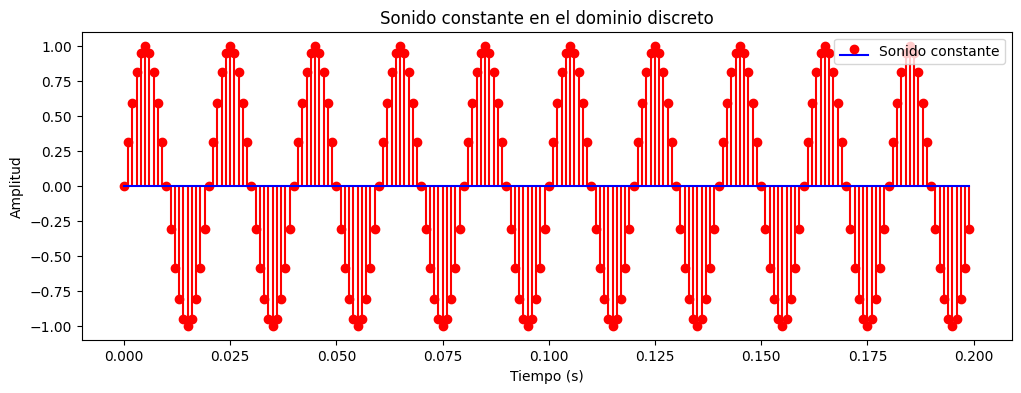

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# Configuración de la simulación
fs = 1000  # Frecuencia de muestreo en Hz
duration = 5  # Duración en segundos
t_discreto = np.arange(0, 0.2, 1/fs)  # Vector de tiempo discreto

# Parámetros del sonido constante
frecuencia = 50  # Frecuencia del sonido en Hz
amplitud = 1  # Amplitud del sonido
fase = 0  # Fase del sonido

# Generar sonido constante
sonido_constante = amplitud * np.sin(2 * np.pi * frecuencia * t_discreto + fase)

# Visualizar el sonido constante en el dominio discreto
plt.figure(figsize=(12, 4))
plt.stem(t_discreto, sonido_constante, label='Sonido constante', basefmt="b-", linefmt="r-", markerfmt="ro")
plt.title('Sonido constante en el dominio discreto')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()
plt.show()


In [99]:
import numpy as np
import sounddevice as sd
import matplotlib.pyplot as plt

# Configuración de la simulación
fs = 44100  # Frecuencia de muestreo en Hz
duration = 1  # Duración en segundos (ajusta según sea necesario)
t_continuo = np.linspace(0, duration, int(fs * duration), endpoint=False)  # Vector de tiempo continuo

# Parámetros del sonido constante simulado
frecuencia_simulado = 50  # Frecuencia del sonido en Hz
amplitud_simulado = 1  # Amplitud del sonido
fase_simulado = 0  # Fase del sonido

# Generar sonido constante simulado
sonido_simulado = amplitud_simulado * np.sin(2 * np.pi * frecuencia_simulado * t_continuo + fase_simulado)

# Capturar sonido ambiente durante la duración especificada
print(f"Capturando sonido ambiente durante {duration} segundos. Presiona Enter cuando hayas terminado.")
sonido_ambiente = sd.rec(int(fs * duration), samplerate=fs, channels=1, dtype=np.float32)
input()

# Detener la grabación
sd.stop()

# Mezclar las dos señales
sonido_mezclado = sonido_simulado + sonido_ambiente[:, 0]

# Reproducir sonido mezclado
print("Reproduciendo sonido mezclado. Presiona Enter cuando hayas terminado.")
sd.play(sonido_mezclado, fs)
sd.wait()
input()

# Visualizar las señales de manera continua
plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.plot(t_continuo, sonido_simulado, label='Sonido simulado', color='b')
plt.title('Sonido simulado en el dominio continuo')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(t_continuo, sonido_ambiente[:, 0], label='Sonido ambiente', color='orange')
plt.title('Sonido ambiente capturado en el dominio continuo')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(t_continuo, sonido_mezclado, label='Sonido mezclado', color='g')
plt.title('Sonido mezclado en el dominio continuo')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()

plt.tight_layout()
plt.show()


Capturando sonido ambiente durante 1 segundos. Presiona Enter cuando hayas terminado.


KeyboardInterrupt: Interrupted by user

Reproduciendo sonido simulado. Presiona Enter cuando hayas terminado.


Capturando sonido ambiente durante 1 segundos. Presiona Enter cuando hayas terminado.


Reproduciendo sonido mezclado. Presiona Enter cuando hayas terminado.


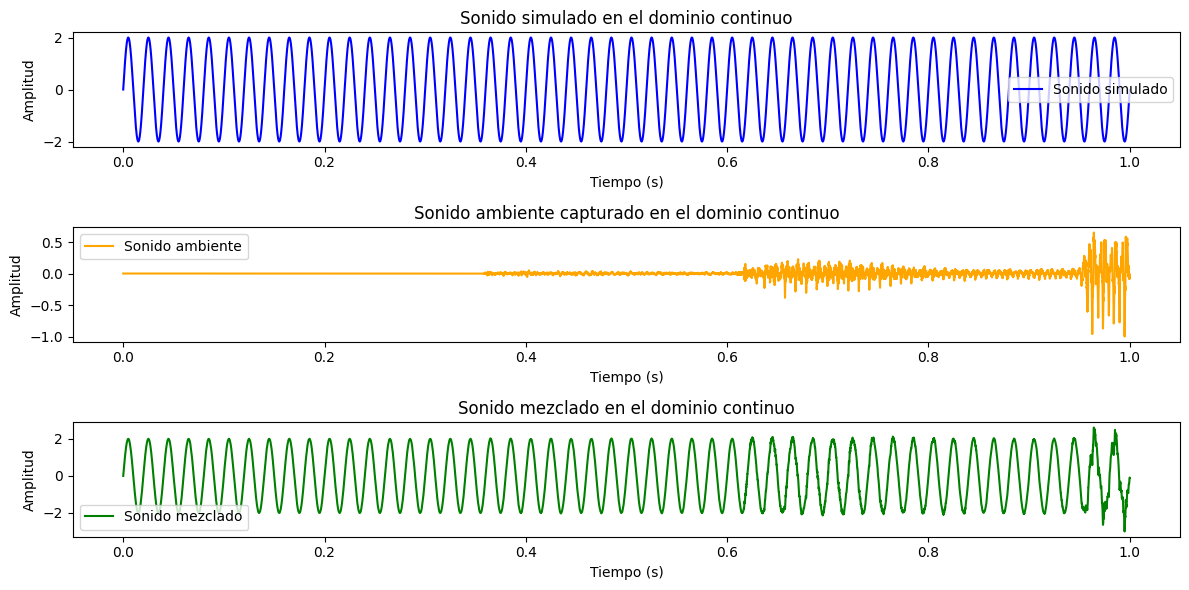

In [100]:
import numpy as np
import sounddevice as sd
import matplotlib.pyplot as plt

# Configuración de la simulación
fs = 44100  # Frecuencia de muestreo en Hz
duration = 1  # Duración en segundos (ajusta según sea necesario)
t_continuo = np.linspace(0, duration, int(fs * duration), endpoint=False)  # Vector de tiempo continuo

# Parámetros del sonido constante simulado
frecuencia_simulado = 50  # Frecuencia del sonido en Hz
amplitud_simulado = 0.5  # Amplitud del sonido simulado (ajusta según sea necesario)
fase_simulado = 0  # Fase del sonido

# Generar sonido constante simulado
sonido_simulado = amplitud_simulado * np.sin(2 * np.pi * frecuencia_simulado * t_continuo + fase_simulado)

# Reproducir sonido simulado
print("Reproduciendo sonido simulado. Presiona Enter cuando hayas terminado.")
sd.play(sonido_simulado, fs)
sd.wait()
input()

# Capturar sonido ambiente durante la duración especificada
print(f"Capturando sonido ambiente durante {duration} segundos. Presiona Enter cuando hayas terminado.")
sonido_ambiente = sd.rec(int(fs * duration), samplerate=fs, channels=1, dtype=np.float32)
input()

# Detener la grabación
sd.stop()

# Normalizar las señales
sonido_simulado /= np.max(np.abs(sonido_simulado))
sonido_ambiente[:, 0] /= np.max(np.abs(sonido_ambiente[:, 0]))

# Ajustar la amplitud del sonido simulado
sonido_simulado *= 2.0

# Mezclar las dos señales
sonido_mezclado = sonido_simulado + sonido_ambiente[:, 0]

# Reproducir sonido mezclado
print("Reproduciendo sonido mezclado. Presiona Enter cuando hayas terminado.")
sd.play(sonido_mezclado, fs)
sd.wait()
input()

# Visualizar las señales de manera continua
plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.plot(t_continuo, sonido_simulado, label='Sonido simulado', color='b')
plt.title('Sonido simulado en el dominio continuo')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(t_continuo, sonido_ambiente[:, 0], label='Sonido ambiente', color='orange')
plt.title('Sonido ambiente capturado en el dominio continuo')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(t_continuo, sonido_mezclado, label='Sonido mezclado', color='g')
plt.title('Sonido mezclado en el dominio continuo')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()

plt.tight_layout()
plt.show()


Reproduciendo sonido simulado. Presiona Enter cuando hayas terminado.


Capturando sonido ambiente durante 1 segundos. Presiona Enter cuando hayas terminado.


Reproduciendo sonido mezclado. Presiona Enter cuando hayas terminado.


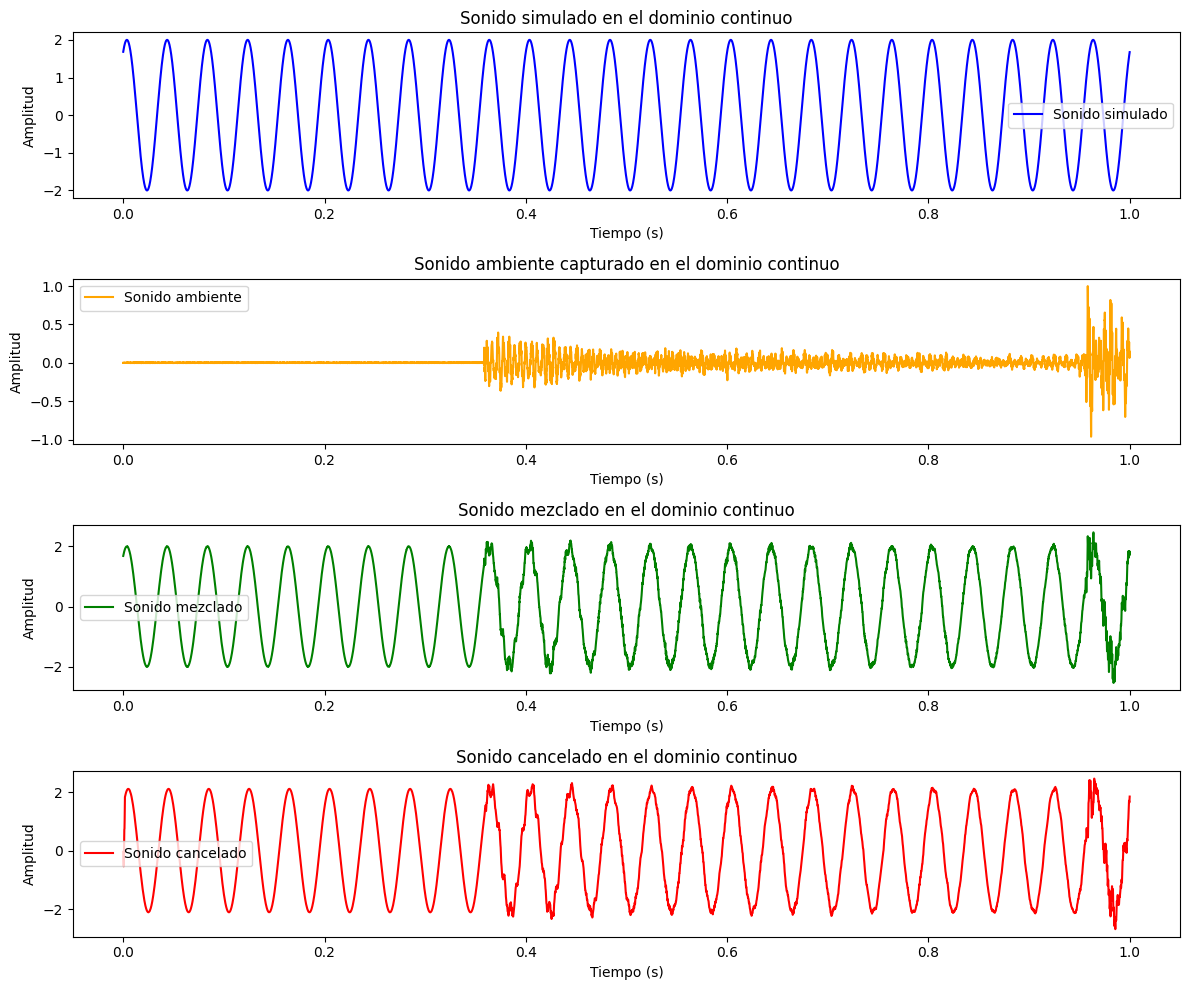

In [118]:
import numpy as np
import sounddevice as sd
import matplotlib.pyplot as plt
from scipy.signal import lfilter

# Configuración de la simulación
fs = 20000  # Frecuencia de muestreo en Hz
duration = 1  # Duración en segundos (ajusta según sea necesario)
t_continuo = np.linspace(0, duration, int(fs * duration), endpoint=False)  # Vector de tiempo continuo

# Parámetros del sonido constante simulado
frecuencia_simulado = 25  # Frecuencia del sonido en Hz
amplitud_simulado = 0.5  # Amplitud del sonido simulado (ajusta según sea necesario)
fase_simulado = 1  # Fase del sonido

# Generar sonido constante simulado
sonido_simulado = amplitud_simulado * np.sin(2 * np.pi * frecuencia_simulado * t_continuo + fase_simulado)

# Reproducir sonido simulado
print("Reproduciendo sonido simulado. Presiona Enter cuando hayas terminado.")
sd.play(sonido_simulado, fs)
sd.wait()
input()

# Capturar sonido ambiente durante la duración especificada
print(f"Capturando sonido ambiente durante {duration} segundos. Presiona Enter cuando hayas terminado.")
sonido_ambiente = sd.rec(int(fs * duration), samplerate=fs, channels=1, dtype=np.float32)
input()

# Detener la grabación
sd.stop()

# Normalizar las señales
sonido_simulado /= np.max(np.abs(sonido_simulado))
sonido_ambiente[:, 0] /= np.max(np.abs(sonido_ambiente[:, 0]))

# Ajustar la amplitud del sonido simulado
sonido_simulado *= 2.0

# Mezclar las dos señales
sonido_mezclado = sonido_simulado + sonido_ambiente[:, 0]

# Reproducir sonido mezclado
print("Reproduciendo sonido mezclado. Presiona Enter cuando hayas terminado.")
sd.play(sonido_mezclado, fs)
sd.wait()
input()

# Implementar un filtro adaptativo LMS para cancelación de sonido
mu = 0.01  # Tasa de aprendizaje del filtro LMS
order = 32  # Orden del filtro

# Inicializar el filtro LMS
filtro_lms = np.zeros(order)

# Aplicar filtro LMS a la señal mezclada
for i in range(order, len(sonido_mezclado)):
    x = sonido_mezclado[i-order:i]
    y_estimado = np.dot(x, filtro_lms)
    error = sonido_mezclado[i] - y_estimado
    filtro_lms = filtro_lms + mu * error * x

# Filtrar la señal mezclada con el filtro LMS aprendido
sonido_cancelado = lfilter(filtro_lms, 1, sonido_mezclado)

# Visualizar las señales de manera continua
plt.figure(figsize=(12, 10))

plt.subplot(4, 1, 1)
plt.plot(t_continuo, sonido_simulado, label='Sonido simulado', color='b')
plt.title('Sonido simulado en el dominio continuo')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(t_continuo, sonido_ambiente[:, 0], label='Sonido ambiente', color='orange')
plt.title('Sonido ambiente capturado en el dominio continuo')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(t_continuo, sonido_mezclado, label='Sonido mezclado', color='g')
plt.title('Sonido mezclado en el dominio continuo')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(t_continuo, sonido_cancelado, label='Sonido cancelado', color='r')
plt.title('Sonido cancelado en el dominio continuo')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()

plt.tight_layout()
plt.show()
